In [1]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-08-09 19:37:07.062289: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1. get data
2. prepare data
3. standardize data
4. train/test split
5. build training and predicting pipeline: that allows to quickly train and evaluate models

In [2]:
#set variables, we start with Disney stock
stock_symbol = 'DIS'
start_date = '2022-01-01'
end_date = '2023-07-30'

In [3]:
df=yf.download(stock_symbol, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,155.830002,157.559998,155.360001,156.759995,156.759995,10222800
2022-01-04,158.589996,160.320007,155.550003,155.729996,155.729996,16582000
2022-01-05,156.520004,159.380005,155.100006,155.190002,155.190002,12272100
2022-01-06,156.240005,157.770004,153.679993,156.899994,156.899994,11095300
2022-01-07,156.899994,159.300003,156.289993,157.830002,157.830002,9554600


In [5]:
#delete nan if any
df = df[['Open', 'High', 'Low', 'Volume', 'Adj Close']].dropna()

In [6]:
# Separate features and target variables, 
#leave 'close' out, as it is the same as 'adj close' in most cases and could bias the model 
X = df[['Open', 'High', 'Low', 'Volume']]
y = df['Adj Close']

In [7]:
#set cutoff date for training, validation and testing data
test_size = 60
validation_size = 60

In [8]:
# Split scaled data into training, validation, and testing sets
X_train = X[:-test_size - validation_size]
X_validation = X[-test_size - validation_size:-test_size]
X_test = X[-test_size:]
y_train = y[:-test_size - validation_size]
y_validation = y[-test_size - validation_size:-test_size]
y_test = y[-test_size:]

In [9]:
# Standardize features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#only apply transform to validation and test data so that data is not leaked
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

In [10]:
#reshape data for lstm: LSTM models expect input data in a 3D shape (samples, time steps, features)
#time steps: is the number of times periods in the dataset(days, months...)that you want to take as input for prediction
# Reshape X_train_scaled

X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

# Reshape X_validation_scaled and X_test_scaled
X_validation_reshaped = X_validation_scaled.reshape((X_validation_scaled.shape[0], X_validation_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))


In [28]:
#build and train the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_scaled.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))


In [29]:
# Define the optimizer with a learning rate
optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate as needed

In [30]:
# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [31]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [32]:
# Train the model with validation data and early stopping
history = model.fit(X_train_reshaped, y_train,
                    epochs=1000,
                    batch_size=50,
                    verbose=2,
                    validation_data=(X_validation_reshaped, y_validation),  # Validation data
                    callbacks=[early_stopping])  # Early stopping


Epoch 1/1000
6/6 - 2s - loss: 13232.6836 - val_loss: 10017.3291 - 2s/epoch - 340ms/step
Epoch 2/1000
6/6 - 0s - loss: 13201.7705 - val_loss: 9992.6191 - 46ms/epoch - 8ms/step
Epoch 3/1000
6/6 - 0s - loss: 13153.8594 - val_loss: 9952.3838 - 46ms/epoch - 8ms/step
Epoch 4/1000
6/6 - 0s - loss: 13072.3906 - val_loss: 9880.5088 - 45ms/epoch - 8ms/step
Epoch 5/1000
6/6 - 0s - loss: 12922.6934 - val_loss: 9744.9004 - 42ms/epoch - 7ms/step
Epoch 6/1000
6/6 - 0s - loss: 12651.3623 - val_loss: 9489.5068 - 42ms/epoch - 7ms/step
Epoch 7/1000
6/6 - 0s - loss: 12224.7686 - val_loss: 9072.1025 - 42ms/epoch - 7ms/step
Epoch 8/1000
6/6 - 0s - loss: 11699.1074 - val_loss: 8577.9814 - 42ms/epoch - 7ms/step
Epoch 9/1000
6/6 - 0s - loss: 11225.1045 - val_loss: 8168.6919 - 41ms/epoch - 7ms/step
Epoch 10/1000
6/6 - 0s - loss: 10894.7021 - val_loss: 7906.3262 - 42ms/epoch - 7ms/step
Epoch 11/1000
6/6 - 0s - loss: 10689.4619 - val_loss: 7745.7368 - 41ms/epoch - 7ms/step
Epoch 12/1000
6/6 - 0s - loss: 10549.715

6/6 - 0s - loss: 5879.2080 - val_loss: 3696.7041 - 40ms/epoch - 7ms/step
Epoch 96/1000
6/6 - 0s - loss: 5838.6782 - val_loss: 3663.6040 - 41ms/epoch - 7ms/step
Epoch 97/1000
6/6 - 0s - loss: 5798.2271 - val_loss: 3630.8430 - 40ms/epoch - 7ms/step
Epoch 98/1000
6/6 - 0s - loss: 5758.6367 - val_loss: 3598.1494 - 40ms/epoch - 7ms/step
Epoch 99/1000
6/6 - 0s - loss: 5718.8022 - val_loss: 3565.8042 - 41ms/epoch - 7ms/step
Epoch 100/1000
6/6 - 0s - loss: 5679.0693 - val_loss: 3533.6218 - 41ms/epoch - 7ms/step
Epoch 101/1000
6/6 - 0s - loss: 5640.1479 - val_loss: 3501.3960 - 41ms/epoch - 7ms/step
Epoch 102/1000
6/6 - 0s - loss: 5600.5845 - val_loss: 3469.5693 - 41ms/epoch - 7ms/step
Epoch 103/1000
6/6 - 0s - loss: 5561.8594 - val_loss: 3437.9297 - 41ms/epoch - 7ms/step
Epoch 104/1000
6/6 - 0s - loss: 5523.1699 - val_loss: 3406.5073 - 42ms/epoch - 7ms/step
Epoch 105/1000
6/6 - 0s - loss: 5484.6694 - val_loss: 3375.2979 - 43ms/epoch - 7ms/step
Epoch 106/1000
6/6 - 0s - loss: 5446.4429 - val_los

Epoch 189/1000
6/6 - 0s - loss: 2969.3164 - val_loss: 1415.4172 - 42ms/epoch - 7ms/step
Epoch 190/1000
6/6 - 0s - loss: 2946.5527 - val_loss: 1398.8451 - 44ms/epoch - 7ms/step
Epoch 191/1000
6/6 - 0s - loss: 2924.1785 - val_loss: 1382.2891 - 45ms/epoch - 7ms/step
Epoch 192/1000
6/6 - 0s - loss: 2901.7085 - val_loss: 1365.9221 - 44ms/epoch - 7ms/step
Epoch 193/1000
6/6 - 0s - loss: 2879.5132 - val_loss: 1349.6687 - 44ms/epoch - 7ms/step
Epoch 194/1000
6/6 - 0s - loss: 2857.5916 - val_loss: 1333.5219 - 44ms/epoch - 7ms/step
Epoch 195/1000
6/6 - 0s - loss: 2835.6560 - val_loss: 1317.6226 - 44ms/epoch - 7ms/step
Epoch 196/1000
6/6 - 0s - loss: 2814.0454 - val_loss: 1301.8058 - 44ms/epoch - 7ms/step
Epoch 197/1000
6/6 - 0s - loss: 2792.4521 - val_loss: 1286.1549 - 44ms/epoch - 7ms/step
Epoch 198/1000
6/6 - 0s - loss: 2771.0276 - val_loss: 1270.6860 - 44ms/epoch - 7ms/step
Epoch 199/1000
6/6 - 0s - loss: 2749.5200 - val_loss: 1255.3867 - 44ms/epoch - 7ms/step
Epoch 200/1000
6/6 - 0s - loss: 

Epoch 283/1000
6/6 - 0s - loss: 1418.7117 - val_loss: 368.4060 - 43ms/epoch - 7ms/step
Epoch 284/1000
6/6 - 0s - loss: 1407.5775 - val_loss: 361.9967 - 40ms/epoch - 7ms/step
Epoch 285/1000
6/6 - 0s - loss: 1396.6753 - val_loss: 355.6384 - 41ms/epoch - 7ms/step
Epoch 286/1000
6/6 - 0s - loss: 1385.5859 - val_loss: 349.4021 - 41ms/epoch - 7ms/step
Epoch 287/1000
6/6 - 0s - loss: 1374.7578 - val_loss: 343.2059 - 42ms/epoch - 7ms/step
Epoch 288/1000
6/6 - 0s - loss: 1364.1063 - val_loss: 337.0581 - 40ms/epoch - 7ms/step
Epoch 289/1000
6/6 - 0s - loss: 1353.2863 - val_loss: 331.0040 - 40ms/epoch - 7ms/step
Epoch 290/1000
6/6 - 0s - loss: 1342.6831 - val_loss: 325.0007 - 40ms/epoch - 7ms/step
Epoch 291/1000
6/6 - 0s - loss: 1332.1886 - val_loss: 319.0046 - 41ms/epoch - 7ms/step
Epoch 292/1000
6/6 - 0s - loss: 1321.7532 - val_loss: 313.0793 - 41ms/epoch - 7ms/step
Epoch 293/1000
6/6 - 0s - loss: 1311.3617 - val_loss: 307.2473 - 43ms/epoch - 7ms/step
Epoch 294/1000
6/6 - 0s - loss: 1301.0178 -

6/6 - 0s - loss: 709.1160 - val_loss: 41.2176 - 42ms/epoch - 7ms/step
Epoch 379/1000
6/6 - 0s - loss: 704.6543 - val_loss: 40.1299 - 41ms/epoch - 7ms/step
Epoch 380/1000
6/6 - 0s - loss: 700.4763 - val_loss: 39.0408 - 41ms/epoch - 7ms/step
Epoch 381/1000
6/6 - 0s - loss: 695.8442 - val_loss: 38.0439 - 41ms/epoch - 7ms/step
Epoch 382/1000
6/6 - 0s - loss: 691.5718 - val_loss: 37.0813 - 41ms/epoch - 7ms/step
Epoch 383/1000
6/6 - 0s - loss: 687.3470 - val_loss: 36.1465 - 42ms/epoch - 7ms/step
Epoch 384/1000
6/6 - 0s - loss: 683.2747 - val_loss: 35.2388 - 41ms/epoch - 7ms/step
Epoch 385/1000
6/6 - 0s - loss: 679.1054 - val_loss: 34.3878 - 42ms/epoch - 7ms/step
Epoch 386/1000
6/6 - 0s - loss: 675.0063 - val_loss: 33.5557 - 41ms/epoch - 7ms/step
Epoch 387/1000
6/6 - 0s - loss: 671.0168 - val_loss: 32.7388 - 42ms/epoch - 7ms/step
Epoch 388/1000
6/6 - 0s - loss: 666.9420 - val_loss: 31.9612 - 42ms/epoch - 7ms/step
Epoch 389/1000
6/6 - 0s - loss: 662.9778 - val_loss: 31.2157 - 42ms/epoch - 7ms/

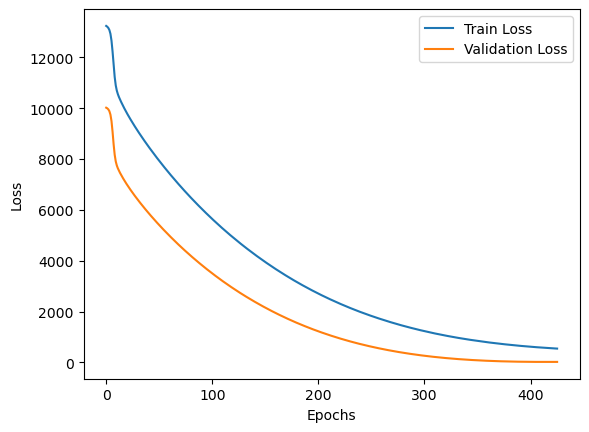

In [33]:
#plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
#make predictions and evaluate model
y_pred = model.predict(X_test_reshaped)



2/2 [==============================] - 1s 3ms/step


In [35]:
#evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)


Mean Squared Error: 104.09411090194772
Root Mean Squared Error: 10.202652150394412


In [36]:
#define a function to calculate MAPE, my objective is to achieve +/- 5% accuracy
def mean_absolute_percentage_error(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100


In [37]:
mape = mean_absolute_percentage_error(y_test, y_pred)
mape

10.762597350196838

In [44]:
y_test, y_pred

(Date
 2023-06-15    92.940002
 2023-06-16    91.320000
 2023-06-20    89.750000
 2023-06-21    88.639999
 2023-06-22    88.489998
 2023-06-23    88.099998
 2023-06-26    88.699997
 2023-06-27    89.059998
 2023-06-28    88.830002
 2023-06-29    88.949997
 2023-06-30    89.279999
 2023-07-03    90.500000
 2023-07-05    89.790001
 2023-07-06    88.739998
 2023-07-07    88.639999
 2023-07-10    88.099998
 2023-07-11    89.489998
 2023-07-12    90.150002
 2023-07-13    90.470001
 2023-07-14    88.620003
 2023-07-17    85.559998
 2023-07-18    85.949997
 2023-07-19    87.040001
 2023-07-20    86.209999
 2023-07-21    87.180000
 2023-07-24    86.599998
 2023-07-25    85.629997
 2023-07-26    85.860001
 2023-07-27    85.360001
 2023-07-28    86.129997
 Name: Adj Close, dtype: float64,
 array([[92.645164],
        [93.11324 ],
        [90.739044],
        [89.72122 ],
        [88.35033 ],
        [87.50226 ],
        [88.055435],
        [89.01842 ],
        [89.41308 ],
        [87.54196 ],
